In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The data is already processed and the trials were already defined...

In [2]:
data = pd.read_csv("../data/modular_theory2007/Data_Modular_Theory2007.csv", engine="c")

In [3]:
def response_gradient(t, n):
    """Return the response gradient"""
    # NOTE(David): No need to return the bin edges, since we'll always use 1s bins
    counts = np.histogram(t, range=(0, int(t.max())), bins=int(t.max()))[0]
    return 60*(counts/n)

def pd_response_gradient(df, trialname):
    """Prepare dataframe for response_gradient"""
    t = df.ix[df["trial_"+trialname]>0, "time_"+trialname]
    n = df.ix[df["trial_"+trialname]>0, "trial_"+trialname].max()
    return response_gradient(t, n)

idx = ((data.phase == "acquisition")
       & (data.session > 20)
       & (data.event == 8))

df_gradient = (data[idx].groupby("subject")                     # 
                        .apply(pd_response_gradient, 'FI120')   # get the response gradient for each rat
                        .apply(pd.Series)                       # auto generate the bins
                        .stack()                                # which are then used as indices
                        .pipe(pd.DataFrame)                     # of the dataframe
                        .reset_index()
                        .rename(columns={"level_1": "bins", 0:"rpm"})
               )

In [4]:
def mt_gradient(x, r, A, μ, σ):
    return r + A*norm.cdf(x, μ, σ)

def pd_fit_mt_gradient(df):
    xdata = df.bins
    ydata = df.rpm

    # Useful starting parameters from the data.
    θ_init = [0, ydata.max(), (2/3)*xdata.max(), (0.2)*(2/3)*xdata.max()]
    θ_bounds = [(0, 0, 0, 0), (ydata.max(), np.inf, xdata.max(), xdata.max())]
    θopt, θcov  = curve_fit(mt_gradient, xdata, ydata, θ_init, bounds=θ_bounds)
    θerr = np.sqrt(np.diag(θcov))
    return θopt, θerr

df_gradient_fit = (df_gradient.groupby("subject")
                              .apply(pd_fit_mt_gradient)         # fit the gradient
                              .apply(pd.Series)                  # unpack θopt and θerr
                              .unstack()                         # transpose
                              .apply(pd.Series)                  # unpack the parameters
                              .reset_index()
                              .rename(columns={"level_0": "is_sem", 0:"r", 1:"A", 2:"μ", 3:"σ"})
                  )

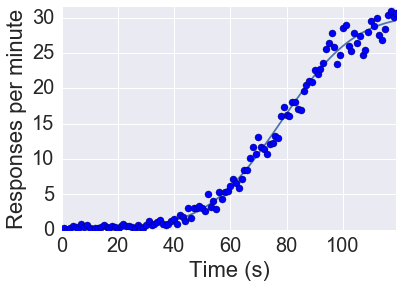

In [5]:
def show_fit(subject):
    xdata = df_gradient[df_gradient.subject==subject].bins
    ydata = df_gradient[df_gradient.subject==subject].rpm
    
    fit = df_gradient_fit.ix[(df_gradient_fit.subject==subject) & ~df_gradient_fit.is_sem]
    yfit = mt_gradient(xdata, *fit[["r", "A", "μ", "σ"]].as_matrix()[0])
    
    fig, ax = plt.subplots()
    ax.plot(xdata, yfit, zorder=1)
    ax.scatter(xdata, ydata, s=50, zorder=2)
    ax.set_xlim((0, xdata.max()))
    ax.set_ylim((0, 1.02*ydata.max()))
    ax.tick_params(labelsize=20)
    ax.set_xlabel("Time (s)", fontsize=22)
    ax.set_ylabel("Responses per minute", fontsize=22)
    

#list(map(show_fit, df_gradient.subject.unique()))
show_fit(433)


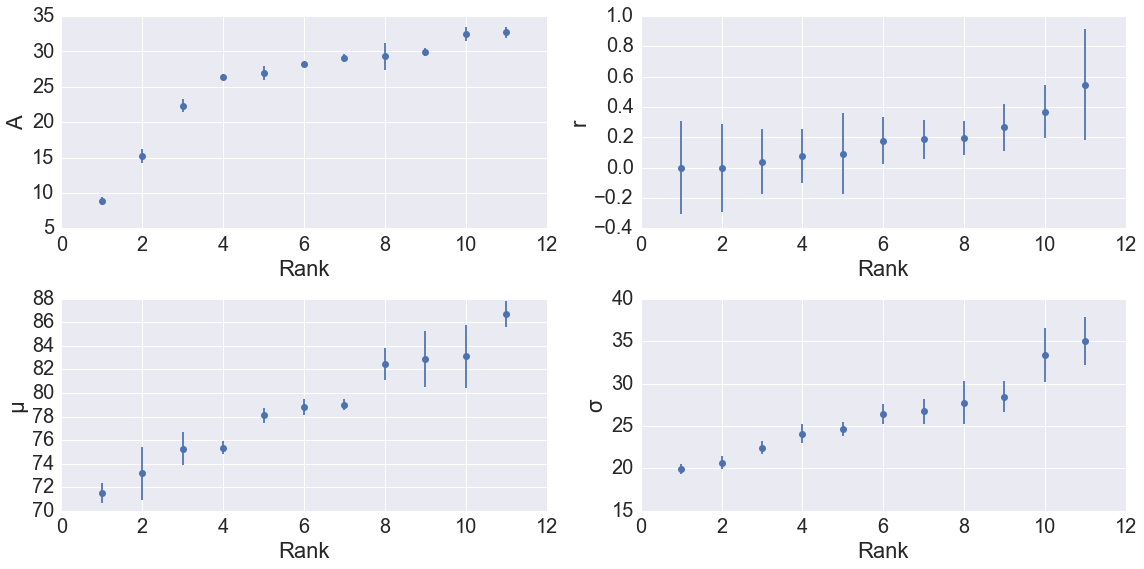

In [7]:
def show_parameter(df, parameter, ax=None):
    θhat = np.vstack([df.ix[df.is_sem==0, parameter].as_matrix(),
                      df.ix[df.is_sem!=0, parameter].as_matrix()]).transpose()
    θhat = θhat[θhat[:, 0].argsort()]
    
    if ax is None:
        fig, ax = plt.subplots()
    #ax.bar(range(1, 1+θhat.shape[0]),
    #       θhat[:,0], align="center")
    ax.errorbar(range(1, 1+θhat.shape[0]),
                θhat[:,0], yerr=θhat[:,1],
                fmt="o", linestyle="")
    ax.set_xlabel("Rank", fontsize=22)
    ax.set_ylabel(parameter, fontsize=22)
    ax.tick_params(labelsize=20)
    return ax

fig, ax = plt.subplots(figsize=(16,8), nrows=2, ncols=2)

show_parameter(df_gradient_fit, "A", ax[0,0])
show_parameter(df_gradient_fit, "r", ax[0,1])
show_parameter(df_gradient_fit, "μ", ax[1,0])
show_parameter(df_gradient_fit, "σ", ax[1,1])

fig.tight_layout()

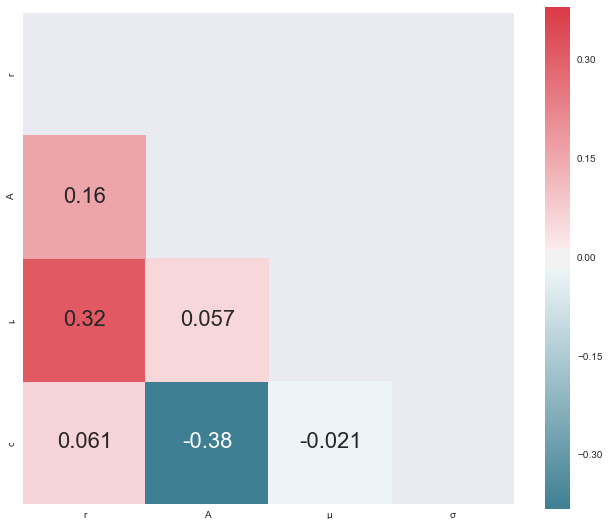

In [28]:
def corrplot(df, parameters):
    corr = df.ix[df.is_sem==0, parameters].corr()

    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
                annot=True, annot_kws={"size":22}, square=True)
    
corrplot(df_gradient_fit, ["r", "A", "μ", "σ"])